# 镰刀菌Case
> 2025-05-23   
> zhenkun.shi@tib.cas.cn

In [11]:

import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../../')
from config import conf as cfg
import pandas as pd
import numpy as np
import json
import plotly.graph_objects as go
import itertools
from tools import btools
from tqdm import tqdm
import rxnrecer as production
import subprocess
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import tools.bioFunctionLib as bfl
from IPython.display import HTML
from pandarallel import pandarallel # 导入pandaralle
FIRST_TIME_RUN = False
pandarallel.initialize(progress_bar=False)
%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 192 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 读取 RMSD 数据


In [12]:
res_base = f'{cfg.CASE_DIR}fusarium_venenatum/rmsd-tmscore/'
res_clean = f'{res_base}clean.tsv'
res_ecrecer = f'{res_base}ecrecer.tsv'
res_catfam = f'{res_base}catfam.tsv'
res_deepec = f'{res_base}deepec.tsv'
res_msa_ec = f'{res_base}msa_ec.tsv'
res_praim = f'{res_base}priam.tsv'
res_rxnrecer = f'{res_base}rxnrecer2ec.tsv'

In [13]:
# 读取结果
clean = pd.read_csv(res_clean, sep='\t')
ecrecer = pd.read_csv(res_ecrecer, sep='\t')
catfam = pd.read_csv(res_catfam, sep='\t')
deepec = pd.read_csv(res_deepec, sep='\t')
msaec = pd.read_csv(res_msa_ec, sep='\t')  
priam = pd.read_csv(res_praim, sep='\t')
rxnrecer = pd.read_csv(res_rxnrecer, sep='\t')

# 添加方法名
clean['method'] = 'clean'
ecrecer['method'] = 'ecrecer'
catfam['method'] = 'catfam'
deepec['method'] = 'deepec'
priam['method'] = 'priam'
msaec['method'] ='msaec'
rxnrecer['method'] = 'rxnrecer'

# 合并结果
res = pd.concat([clean, ecrecer, catfam, priam,deepec, msaec, rxnrecer])

# 强制转换为字符串并 strip 掉空格
res['pdb2'] = res['pdb2'].astype(str).str.strip()
res['method'] = res['method'].astype(str).str.strip()

# 重新分组提取最大值记录
res_dedup = res.loc[
    res.groupby(['pdb2', 'method'], sort=False)['tm_score_chain1'].idxmax()
].drop_duplicates(subset=['pdb2', 'method'], keep='first').reset_index(drop=True)

res_dedup = res_dedup.sort_values(by=['pdb2', 'tm_score_chain1', 'EC_number'], ascending=False).reset_index(drop=True)

res_dedup.head(20)

/tmp/ipykernel_3803138/2827543725.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  rxnrecer = pd.read_csv(res_rxnrecer, sep='\t')


,EC_number,pdb1,pdb2,tm_score_chain1,tm_score_chain2,tm_score_max,tm_score_avg,rmsd_tmalign,rmsd_pymol,method
0,3.1.1.3,3QZU,XP_065466154.1,0.76897,0.27388,0.76897,0.521425,3.15,23.59,rxnrecer
1,3.1.1.1,4FTW,XP_065466154.1,0.74756,0.31817,0.74756,0.532865,3.30,18.692,deepec
2,3.1.1.3,6J1P,XP_065466154.1,0.56627,0.34040,0.56627,0.453335,4.62,15.623,msaec
3,3.1.1.3,7APP,XP_065466154.1,0.46959,0.25458,0.46959,0.362085,5.16,25.137,ecrecer
4,2.1.1.86,5LAA,XP_065466153.1,0.16899,0.34847,0.34847,0.258730,4.24,9.155,clean
5,4.2.1.159,4J7H,XP_065466152.1,0.17246,0.31429,0.31429,0.243375,5.66,18.144,clean
6,5.4.99.30,8CID,XP_065466151.1,0.07215,0.28904,0.28904,0.180595,3.74,11.943,clean
7,3.4.14.10,3LXU,XP_065466150.1,0.20883,0.37348,0.37348,0.291155,4.23,24.216,clean
8,2.3.2.27,5XIU,XP_065466149.1,0.66907,0.28095,0.66907,0.475010,2.36,8.856,clean
9,2.7.13.3,2KSF,XP_065466148.1,0.43226,0.41161,0.43226,0.421935,2.75,5.292,clean


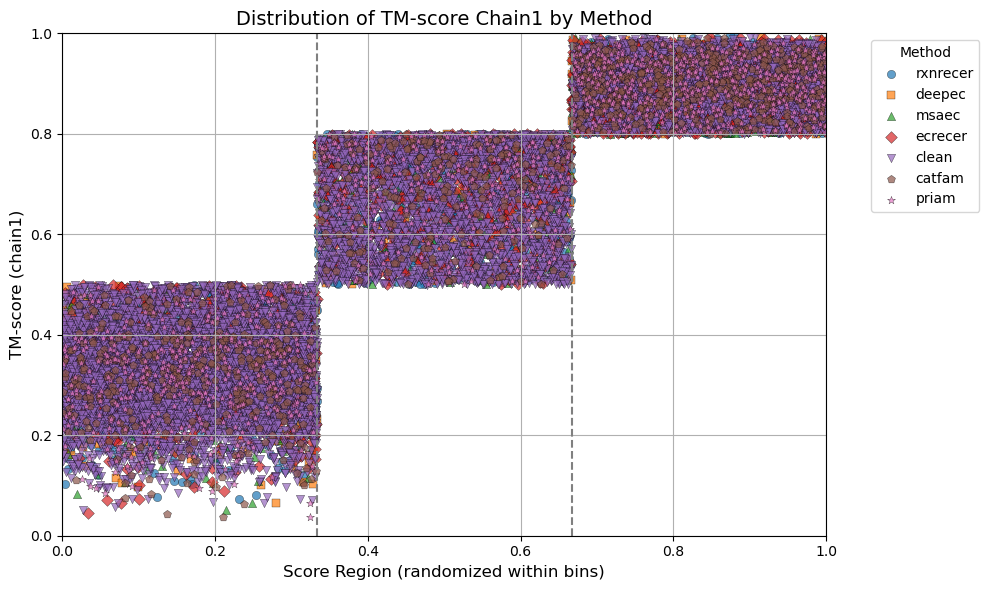

In [4]:

df = res_dedup.copy()
df['tm_score_chain1'] = df['tm_score_chain1'].astype(float)

# 设置颜色和形状（你可以根据实际方法数量扩展）
methods = df['method'].unique()
cmap = plt.colormaps.get_cmap('tab10')  # 正确写法
colors = [cmap(i) for i in range(len(methods))]  # 生成每个方法的颜色
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'X', 'P', 'H']

# 初始化图
plt.figure(figsize=(10, 6))

# 画三条分区竖线
plt.axvline(x=1/3, color='gray', linestyle='--')
plt.axvline(x=2/3, color='gray', linestyle='--')

# 为每种方法分别绘图
for idx, method in enumerate(methods):
    sub_df = df[df['method'] == method]
    
    # 按 tm_score_chain1 值将点随机撒在对应区间内
    x = []
    for score in sub_df['tm_score_chain1']:
        if score > 0.8:
            x.append(np.random.uniform(2/3, 1))
        elif score >= 0.5:
            x.append(np.random.uniform(1/3, 2/3))
        else:
            x.append(np.random.uniform(0, 1/3))
    
    y = sub_df['tm_score_chain1']
    plt.scatter(x, y, label=method, alpha=0.7, 
            c=[colors[idx]], marker=markers[idx % len(markers)], edgecolors='k', linewidths=0.3)

# 设置坐标轴和图例
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Score Region (randomized within bins)', fontsize=12)
plt.ylabel('TM-score (chain1)', fontsize=12)
plt.title('Distribution of TM-score Chain1 by Method', fontsize=14)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:

def plot_kde_heatmap(df_selected, selected_methods, method_colors, save_path=None):
    def randomize_x(tm_scores):
        x_coords = []
        for score in tm_scores:
            if score > 0.8:
                x_coords.append(np.random.uniform(0.8, 1))
            elif score >= 0.5:
                x_coords.append(np.random.uniform(0.5, 0.8))
            else:
                x_coords.append(np.random.uniform(0, 0.5))
        return np.array(x_coords)
    
    plt.figure(figsize=(11, 6))
    legend_handles = []
    for method in selected_methods:
        sub = df_selected[df_selected['method'] == method].copy()
        x_rand = randomize_x(sub['tm_score_chain1'])
        try:
            sns.kdeplot(
                x=x_rand,
                y=sub['tm_score_chain1'],
                fill=True,
                alpha=0.35,
                levels=10,
                color=method_colors[method]
            )
            legend_handles.append(Patch(facecolor=method_colors[method], label=method, alpha=0.5))
        except Exception as e:
            print(f"Skipping {method} due to KDE error: {e}")

    plt.axvline(0.5, linestyle='--', color='gray')
    plt.axvline(0.8, linestyle='--', color='gray')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Score Region (randomized)')
    plt.ylabel('TM-score')
    plt.title('KDE Heatmap of TM-score (chain1): clean vs rxnrecer')
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.legend(handles=legend_handles, title='Method', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    return plt

def plot_tm_score_bar(df_selected, selected_methods, method_colors, save_path=None):
    # 区间标签
    def bin_label(score):
        if score > 0.8:
            return '>0.8'
        if score > 0.7:
            return '0.7-0.8'
        elif score > 0.6:
            return '0.6-0.7'
        elif score > 0.5:
            return '0.5-0.6'
        elif score >= 0.4:
            return '0.4-0.5'
        else:
            return '<0.4'
    df_selected = df_selected.copy()
    df_selected['score_bin'] = df_selected['tm_score_chain1'].apply(bin_label)
    bin_percent = (
        df_selected.groupby(['method', 'score_bin'])
        .size()
        .unstack(fill_value=0)
    )
    bin_percent = bin_percent.div(bin_percent.sum(axis=1), axis=0) * 100
    # 固定顺序
    score_bins = ['<0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7','0.7-0.8', '>0.8']
    bin_percent = bin_percent.loc[selected_methods, score_bins]

    color_list = [method_colors[m] for m in selected_methods]
    ax = bin_percent.T.plot(
        kind='bar',
        figsize=(9, 6),
        color=color_list,
        rot=0,
        edgecolor='black'
    )
    plt.ylabel('Percentage of Samples (%)')
    plt.title('Distribution of TM-score per Region')
    plt.xticks(rotation=0)
    plt.legend(title='Method')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    return plt
    

def plot_tm_score_analysis(df, selected_methods, method_colors, save_prefix=None):
    # 只保留需要的方法
    df_selected = df[df['method'].isin(selected_methods)].copy()
    # KDE 热力图
    plt_kde =plot_kde_heatmap(
        df_selected, selected_methods, method_colors,
        save_path=f"{save_prefix}_kde.pdf" if save_prefix else None
    )
    # 柱状图
    plt_bin =plot_tm_score_bar(
        df_selected, selected_methods, method_colors,
        save_path=f"{save_prefix}_bar.pdf" if save_prefix else None
    )
    # 显著性检验
    method1, method2 = selected_methods
    tm1 = df_selected[df_selected['method'] == method1]['tm_score_chain1']
    tm2 = df_selected[df_selected['method'] == method2]['tm_score_chain1']
    stat, p = mannwhitneyu(tm2, tm1, alternative='greater')
    print(f'Mann-Whitney U 检验结果: U={stat}, p={p:.2e}')
    if p < 0.05:
        print(f"差异显著: {method2} 显著高于 {method1}")
    else:
        print("差异不显著")
        
    

    return plt_kde, plt_bin



In [188]:
126/4.5

28.0

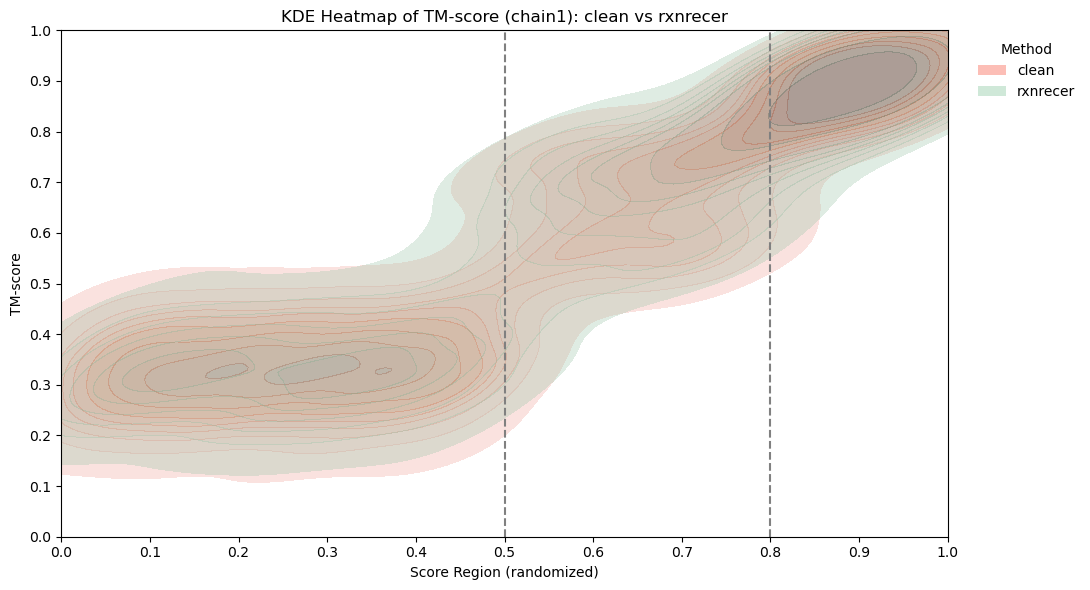

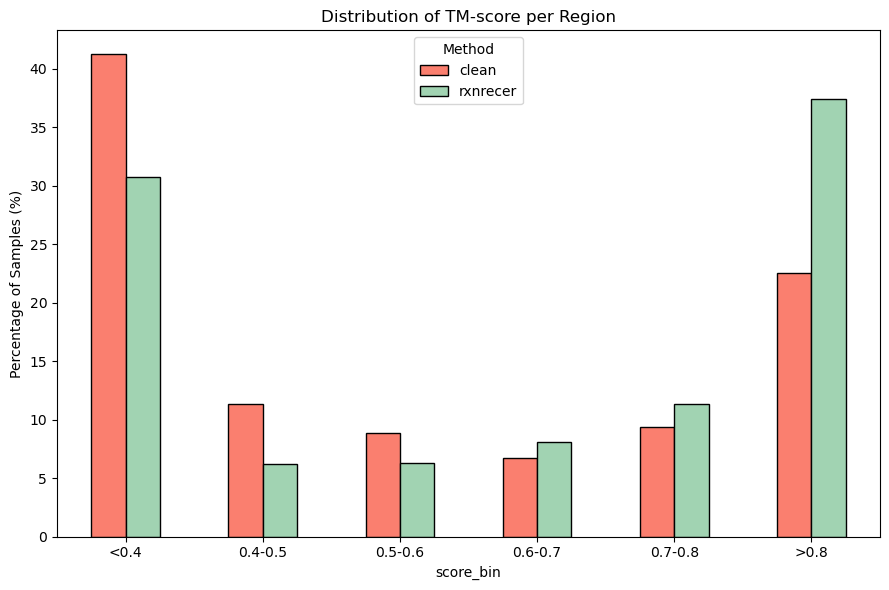

Mann-Whitney U 检验结果: U=17281769.0, p=4.33e-54
差异显著: rxnrecer 显著高于 clean


In [10]:
# 用法示例
plt_kde, plt_bin = plot_tm_score_analysis(
    df,
    selected_methods=['clean', 'rxnrecer'],
    method_colors={'clean': '#FA7F6F', 'rxnrecer': '#A1D3B2'},
    save_prefix='myfig'
)

In [ ]:
colors = [
    '#8ECFC9',  # 绿色系
    '#FFBE7A',  # 橙色系
    '#FA7F6F',  # 红色系
    '#82B0D2',  # 蓝色系
    '#BEB8DC',  # 紫色系
    '#E7DAD2',  # 米色系
    '#999999',  # 灰色系
    '#A1D3B2',  # 浅绿色
    '#F5C98A',  # 浅橙色
    '#F9988C',  # 浅红色
    
    '#6FB7AA',  # 深绿色，协调 #8ECFC9
    '#FFA351',  # 深橙色，协调 #FFBE7A
    '#E45756',  # 深红色，协调 #FA7F6F
    '#5A9BD4',  # 深蓝色，协调 #82B0D2
    '#9D81BA',  # 深紫色，协调 #BEB8DC
    '#C9C1B6'   # 深米色，协调 #E7DAD2
]


In [161]:
# 只选 clean 和 rxnrecer
selected_methods = ['clean', 'rxnrecer']
df_selected = df[df['method'].isin(selected_methods)].copy()

# 手动设置颜色，与你的图例一致
method_colors = {
    'clean': '#FA7F6F',     # 浅蓝
    'rxnrecer': '#A1D3B2'   # 柔红
}


In [50]:
rmsd_tmalign_clean =clean.rmsd_tmalign.mean()
rmsd_tmalign_deepec = deepec.rmsd_tmalign.mean()
rmsd_tmalign_catfam = catfam.rmsd_tmalign.mean()
rmsd_tmalign_msaec = msaec.rmsd_tmalign.mean()
rmsd_tmalign_ecrecer = ecrecer.rmsd_tmalign.mean()
rmsd_tmalign_rxnrecer = rxnrecer.rmsd_tmalign.mean()

print(f"rmsd_tmalign_clean: {rmsd_tmalign_clean:.4f}")
print(f"rmsd_tmalign_deepec: {rmsd_tmalign_deepec:.4f}")
print(f"rmsd_tmalign_catfam: {rmsd_tmalign_catfam:.4f}")
print(f"rmsd_tmalign_msaec: {rmsd_tmalign_msaec:.4f}")
print(f"rmsd_tmalign_ecrecer: {rmsd_tmalign_ecrecer:.4f}")
print(f"rmsd_tmalign_rxnrecer: {rmsd_tmalign_rxnrecer:.4f}")

rmsd_tmalign_clean: 5.4611
rmsd_tmalign_deepec: 3.8142
rmsd_tmalign_catfam: 3.8177
rmsd_tmalign_msaec: 3.6689
rmsd_tmalign_ecrecer: 4.2647
rmsd_tmalign_rxnrecer: 4.6379


In [ ]:
rmsd_tmalign_clean: 5.4611
rmsd_tmalign_deepec: 3.8142
rmsd_tmalign_catfam: 3.8177
rmsd_tmalign_msaec: 3.6689
rmsd_tmalign_ecrecer: 4.2647

In [28]:
tm_score_avg_clean = clean.tm_score_avg.mean()
tm_score_avg_deepec = deepec.tm_score_avg.mean()
tm_score_avg_catfam = catfam.tm_score_avg.mean()
tm_score_avg_msaec = msaec.tm_score_avg.mean()
tm_score_avg_ecrecer = ecrecer.tm_score_avg.mean()

print(f"tm_score_avg_clean: {tm_score_avg_clean:.4f}")
print(f"tm_score_avg_deepec: {tm_score_avg_deepec:.4f}")
print(f"tm_score_avg_catfam: {tm_score_avg_catfam:.4f}")    
print(f"tm_score_avg_msaec: {tm_score_avg_msaec:.4f}")
print(f"tm_score_avg_ecrecer: {tm_score_avg_ecrecer:.4f}")

tm_score_avg_clean: 0.3016
tm_score_avg_deepec: 0.5478
tm_score_avg_catfam: 0.5340
tm_score_avg_msaec: 0.5707
tm_score_avg_ecrecer: 0.5013


In [185]:

def summarize_metrics_by_method(method_dict, columns):
    summary_rows = []

    for method_name, df in method_dict.items():
        for col in columns:
            if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
                desc = df[col].describe()
                summary_rows.append({
                    'Method': method_name,
                    'Metric': col,
                    'Count': desc.get('count', float('nan')),
                    'Mean': desc.get('mean', float('nan')),
                    'Std': desc.get('std', float('nan')),
                    'Min': desc.get('min', float('nan')),
                    '25%': desc.get('25%', float('nan')),
                    '50%': desc.get('50%', float('nan')),
                    '75%': desc.get('75%', float('nan')),
                    'Max': desc.get('max', float('nan'))
                })
            else:
                # 如果列不存在或不是数值类型，填 NaN
                summary_rows.append({
                    'Method': method_name,
                    'Metric': col,
                    'Count': float('nan'),
                    'Mean': float('nan'),
                    'Std': float('nan'),
                    'Min': float('nan'),
                    '25%': float('nan'),
                    '50%': float('nan'),
                    '75%': float('nan'),
                    'Max': float('nan')
                })

    return pd.DataFrame(summary_rows)

# 要统计的列
columns_to_summarize = [
    'tm_score_chain1', 'tm_score_chain2', 'tm_score_max',
    'tm_score_avg', 'rmsd_tmalign', 'rmsd_pymol'
]

# 调用函数生成汇总表
summary_df = summarize_metrics_by_method({
    'CLEAN': clean,
    'ECRECer': ecrecer,
    'CatFam': catfam,
    'DeepEC': deepec,
    'MSA-EC': msaec,
    'RXNRECer': rxnrecer
}, columns_to_summarize).sort_values(['Metric', 'Method']).reset_index(drop=True)

summary_df

,Method,Metric,Count,Mean,Std,Min,25%,50%,75%,Max
0,CLEAN,rmsd_pymol,394658.0,19.550240,12.280421,0.019000,10.427000,18.820500,27.089750,127.41200
1,CatFam,rmsd_pymol,29352.0,11.278742,12.339451,0.221000,1.171000,4.553000,19.943250,102.00700
2,DeepEC,rmsd_pymol,23795.0,10.906527,12.375454,0.039000,1.064000,4.000000,19.132000,127.58200
3,ECRECer,rmsd_pymol,67874.0,13.024698,11.853097,0.149000,1.625000,11.663500,20.906000,146.91200
4,MSA-EC,rmsd_pymol,46837.0,10.158533,11.611499,0.015000,1.201000,3.357000,18.190000,97.42400
5,RXNRECer,rmsd_pymol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CLEAN,rmsd_tmalign,394658.0,5.461143,1.663509,0.000000,4.470000,5.650000,6.590000,11.76000
7,CatFam,rmsd_tmalign,29352.0,3.817655,2.006844,0.010000,2.190000,3.190000,5.440000,11.52000
8,DeepEC,rmsd_tmalign,23795.0,3.814175,2.053335,0.010000,2.120000,3.220000,5.420000,11.52000
9,ECRECer,rmsd_tmalign,67874.0,4.264684,1.993638,0.010000,2.570000,3.970000,5.880000,11.79000


## 1.2 Trembl data preparation